In [1]:
using SpecialFunctions, IterTools, HardSphereDynamics, StatsBase # For Std Error.

In [2]:
?sem

search: sem isempty DenseMatrix SegmentationFault isperm basename systemerror



```
sem(x)
```

Return the standard error of the mean of collection `x`, i.e. `sqrt(var(x, corrected=true) / length(x))`.


Aqui abajo Rosa define todos los resultados téoricos para cualquier número de dimensiones, siempre
que no haya "sombras prohibidas" (es decir, que las bolas siempre quepan unas al lado de otras).

In [36]:

function SphereArea(n)
    return 2*(pi^(n/2))/gamma(n/2)
end

function NormalizationFactor(n, balls=2)
    d = 2*n
    return SphereArea(d)/SphereArea(d-1)*(d-1)
end

function Ak(boxdims,m)
    result = 0
    for aks in subsets(boxdims, m)
        result += prod(aks)
    end
    return result
end

function AvailableVolume(n, boxdims, r)
    vol = prod((2*boxdims).^2)
    for k in 0:n
        vol -= (4^n)*(pi)^(n/2-k/2)*r^(k+n)/gamma(k/2+n/2+1)*Ak(boxdims, n-k)*(-1)^k
    end
    return vol
end

function SphereCollisionArea(n, boxdims, r)
    area = 0 
    for k in 0:n
        area += 2^(2*n+1/2)*(pi^(n/2-k/2))*(r^(k+n-1))/gamma(k/2+n/2)*Ak(boxdims, n-k)*(-1)^k
    end
    return area
end

function WallCollisionArea(n, boxdims, r, dim)
    otherboxdims = deleteat!(copy(boxdims),dim)
    area = prod((2*otherboxdims).^2)*(2*boxdims[dim])
    for k in 0:(n-1)
        area -= 2^(2*n-2)*(pi^(n/2 - k/2))*(r^(k+n))/gamma(k/2+n/2+1)*(-1)^k*Ak(otherboxdims, n-1-k)
    end
    return area
end

function SphereCollisionTime(n, boxdimsh, r)
    boxdimsa = boxdimsh/2 .- r 
    return NormalizationFactor(n)*AvailableVolume(n, boxdimsa, r)/SphereCollisionArea(n, boxdimsa, r)
end

function WallCollisionTime(n, boxdimsh, r, dim)
    boxdimsa = boxdimsh/2 .- r 
    return NormalizationFactor(n)*AvailableVolume(n, boxdimsa, r)/WallCollisionArea(n, boxdimsa, r, dim)
end
    
function HoppingCollisionTime(n, boxdimsh, r, dim)
    boxdimsa = boxdimsh/2 .- r 
    otherboxdims = deleteat!(copy(boxdimsa),dim)
    #if r < minimum(boxdimsh)/4
        result= NormalizationFactor(n)*AvailableVolume(n, boxdimsa, r)/
           AvailableVolume(n-1, otherboxdims, r)/2^(2.5)/boxdimsa[dim]
    #else
    #    result=1.0
    #end
    
end

function CollisionTimesTheo(r, n=3, boxdimsh = [1.0, 1.5, 1.75])
    wall_times = []
    hop_times = []
    for dim in 1:n
        w = WallCollisionTime(n, boxdimsh, r, dim)
        push!(wall_times, w, w)
        push!(hop_times, HoppingCollisionTime(n, boxdimsh, r, dim))
    end
    result = hcat(r , SphereCollisionTime(n, boxdimsh, r), wall_times..., hop_times...)
    return result
end

CollisionTimesTheo (generic function with 3 methods)

In [37]:
using Parameters, Statistics, HardSphereDynamics, StaticArrays

function BallsRelativeSign(state)
    b1, b2 = state
    return broadcast(sign, b1.x - b2.x)
end

function mean_interval(times)
    return mean(diff(times))
end

h1 = 1.0
h2 = 1.5
h3 = 1.75
r = 0.1
Nmax=10^7

function CollisionTimesSim(r, h1 = 1.0, h2 = 1.5, h3 = 1.75 ,num_collisions = 10^7)
    table = HardSphereDynamics.RectangularBox(SA[-h1/2, -h2/2, -h3/2],
                                              SA[+h1/2, +h2/2, +h3/2])

    n = 3
    spheres = 2
    fluid = HardSphereFluid{n,Float64}(table, spheres, r)
    initial_condition!(fluid.balls, table)

    # set up simulation:
    collision_type = ElasticCollision()
    flow_type = ExternalFieldFlow(SA[0.0, 0.0, 0.0])
    event_handler = AllToAll(fluid, flow_type)

    simulation =  HardSphereSimulation(
        fluid, event_handler, flow_type, collision_type);

    @unpack fluid, flow_dynamics, collision_dynamics, event_handler = simulation
    states = [deepcopy(fluid.balls)]
    times = [0.0]
    collision_types = [:none]
    partner2 = [0] 
    partner1 = [0]
    hopping_times = []
    hopping_directions = []
    for i in 1:num_collisions
        HardSphereDynamics.flow!(fluid.balls, (event_handler.next_collision_time - simulation.current_time), 
            flow_dynamics)
        simulation.current_time = event_handler.next_collision_time
        push!(collision_types, event_handler.collision_type)
        push!(partner2, event_handler.partner2)
        push!(partner1, event_handler.partner1)
        HardSphereDynamics.collide!(fluid, event_handler, collision_dynamics)
        HardSphereDynamics.find_collision!(event_handler, fluid, flow_dynamics)
        push!(states, deepcopy(fluid.balls))
        push!(times, simulation.current_time)
        prev, current = states[i:i+1]
        signprev, signcurrent = broadcast(BallsRelativeSign,[prev, current])
        if any(signprev .!= signcurrent)
            b1, b2 = states[i]
            start_time, final_time = times[i:i+1]
            hop_times = start_time .+( b1.x - b2.x)./(b2.v - b1.v)
            for (dir, time) in enumerate(hop_times)
                if all([time>=start_time, time<=final_time])
                    push!(hopping_times, time)
                    push!(hopping_directions, dir)
                end
            end
        end
    end
    
    wall_idx = (collision_types.== :wall_collision).&(partner1.== 1)
    wall_times = times[wall_idx];
    which_wall = partner2[wall_idx];
    wall_means = []
    
    # The std errros are no longer missin!
    wall_errors = []
    hop_errors  = []
    
    for i in 1:length(fluid.box.walls)
        
        enparedcorrecta=wall_times[which_wall .== i]
        error=sem(diff(enparedcorrecta))
        nn=length(enparedcorrecta)
     #   println( " En la pared $i, chocamos $nn veces")
        
        push!(wall_means,mean_interval(enparedcorrecta))
        push!(wall_errors, error)
        
    end
    
    hop_means = []
    hop_errors= []

    for i in 1:n
        
        cual_hop=hopping_times[hopping_directions .== i]
        error=sem(diff(cual_hop))
        ll=length(cual_hop)
       # println("en el hop $i, hopamos $ll veces")
        
        push!(hop_means, mean_interval(cual_hop))
        push!(hop_errors, error)
        
    end
    
    colision=times[collision_types.== :disc_collision]
    meandisc=mean_interval(colision)
    errorcol=sem(diff(colision))
    
    
    result=hcat(r, meandisc, errorcol,wall_means..., wall_errors..., hop_means..., hop_errors...)
    
    return result
        
end

CollisionTimesSim (generic function with 5 methods)

In [38]:
@time chin, pun, cuaz, el, eslam = CollisionTimesSim(0.01)

 99.520807 seconds (237.10 M allocations: 14.289 GiB, 15.21% gc time)


1×21 Array{Float64,2}:
 0.01  2092.9  36.9798  5.79636  …  0.000951763  0.00168248  0.00232849

In [39]:
37*115/60

70.91666666666667

In [40]:
eslam

5.796360317913618

In [41]:
rs = 0.01:0.01:0.375
theo = vcat(broadcast(CollisionTimesTheo, rs)...);
sim = vcat(broadcast(CollisionTimesSim, rs)...);

In [42]:
using JLD

In [48]:
nota="Los Resultados Teoricos y Simulados estan en dos tablas.
Prmero las bolas entre ellas.
Luego vienen en Teoricas los golpes con las paredes de un bola 
contra una pared asi: 
Columna   Pared
3         x positiva
4         x negativa
5         y positiva
6         y negativa
7         z positiva
8         z negativa
Luego vienen los hops, 
9         hop x
10         hop y
11        hop z
En las simulaciones, entre cada columna, en el mismo orden, hay una columna 
de errores estandar.
"
otranota="La variable h contiene los tamaños de la caja. La variable Nmax el numero de collisiones total."
onde="simulaRosa20210115-1655.jld"

h=(h1,h2,h3)

save(onde, "nota01", nota, "nota02", otranota, 
    "teoricas" , theo, "numericas", sim, "h", h, "Nmax", Nmax)

In [49]:
sim

37×21 Array{Float64,2}:
 0.01  2128.46      37.8525       …  0.00101359   0.00178863  0.00215784
 0.02   527.861      4.73092         0.00100874   0.00171128  0.00231934
 0.03   225.526      1.32685         0.000951899  0.00183895  0.00223795
 0.04   124.887      0.551992        0.000921651  0.00177875  0.00229163
 0.05    77.9724     0.27195         0.000902427  0.00183356  0.00232471
 0.06    52.819      0.153734     …  0.000886395  0.00179076  0.00234758
 0.07    37.9044     0.0944176       0.00088955   0.0018372   0.00240333
 0.08    28.4862     0.0622313       0.000879684  0.00187438  0.00246904
 0.09    21.9902     0.0425329       0.000881946  0.00191608  0.00250565
 0.1     17.502      0.0308671       0.000857939  0.00206455  0.00269757
 0.11    14.0417     0.0221773    …  0.000858204  0.00197715  0.00276201
 0.12    11.584      0.0168615       0.000850069  0.00204182  0.00284933
 0.13     9.64287    0.0130148       0.000842169  0.00212351  0.00302042
 ⋮                         

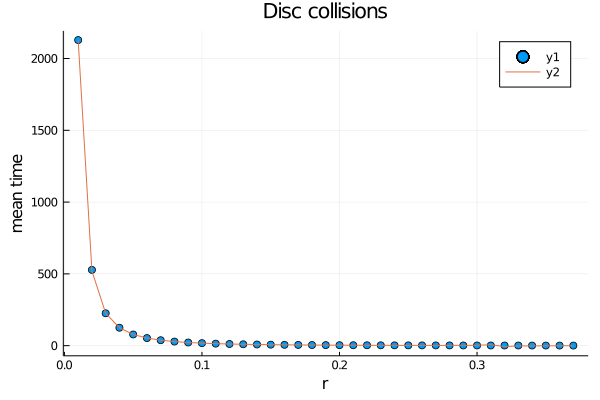

In [50]:
using Plots
scatter(rs,sim[:,2])
plot!(rs,theo[:,2])
title!("Disc collisions")
xlabel!("r")
ylabel!("mean time")

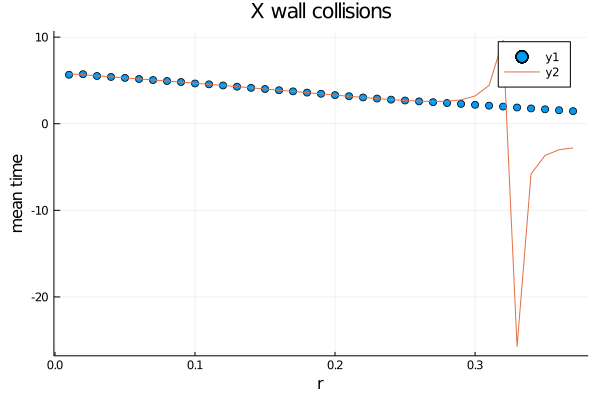

In [46]:
scatter(rs,sim[:,4])
plot!(rs,theo[:,3])
title!("X wall collisions")
xlabel!("r")
ylabel!("mean time")

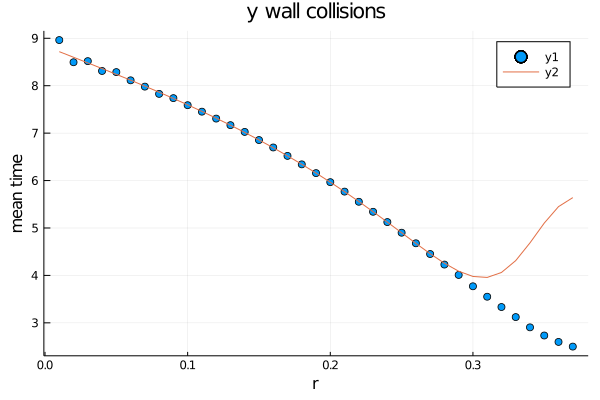

In [47]:
scatter(rs,sim[:,6])
plot!(rs,theo[:,5])
title!("y wall collisions")
xlabel!("r")
ylabel!("mean time")

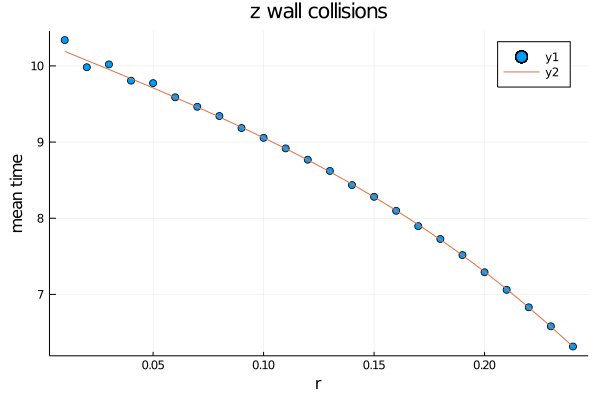

In [114]:
scatter(rs,sim[:,8])
plot!(rs,theo[:,7])
title!("z wall collisions")
xlabel!("r")
ylabel!("mean time")

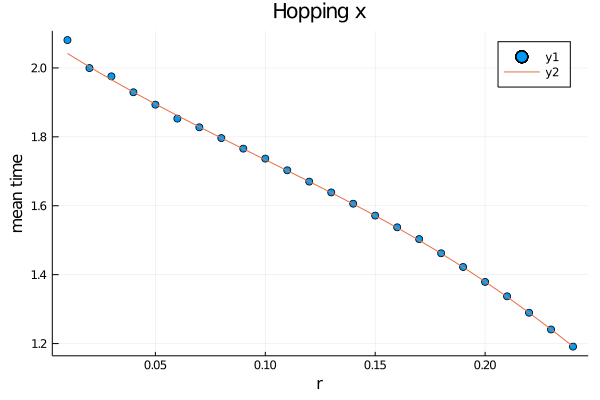

In [126]:
scatter(rs,sim[:,16] )
plot!(rs, theo[:, 9])
title!("Hopping x")
xlabel!("r")
ylabel!("mean time")

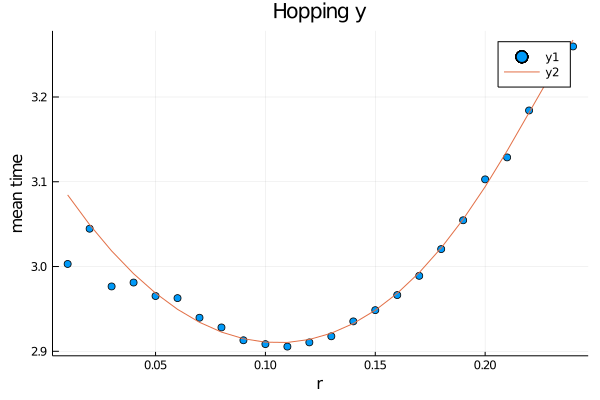

In [127]:
scatter(rs,sim[:,17])
plot!(rs, theo[:,10])
title!("Hopping y")
xlabel!("r")
ylabel!("mean time")

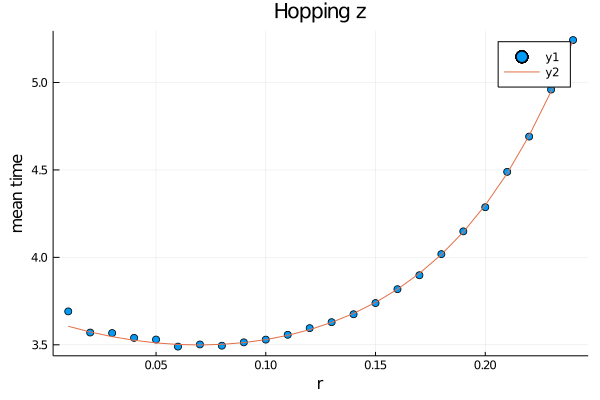

In [128]:
scatter(rs,sim[:,18] )
plot!(rs,theo[:,11])
title!("Hopping z")
xlabel!("r")
ylabel!("mean time")

A box with different dimensions

In [110]:
h1 = 1
h2 = 2
h3 = 3
theo2 = vcat(broadcast(function (r)  CollisionTimesTheo(r, 3, [h1,h2,h3]) end, rs)...);
sim2 = vcat(broadcast(function (r) CollisionTimesSim(r, h1, h2, h3) end , rs)...);

nota="Los Resultados Teoricos y Simulados estan en dos tablas.
Primera columna son los radios.
Prmero las bolas entre ellas.
Luego vienen en Teoricas los golpes con las paredes de un bola 
contra una pared asi: 
Columna   Pared
2         x positiva
3         x negativa
4         y positiva
5         y negativa
6         z positiva
7         z negativa
Luego vienen los hops, 
8         hop x
9         hop y
10        hop z
En las simulaciones, entre cada columna, en el mismo orden, hay una columna 
de errores estandar.
"
otranota="La variable h contiene los tamaños de la caja. La variable Nmax el numero de collisiones total."
onde="simulaRosa20201216-1930.jld"

h=(h1,h2,h3)

save(onde, "nota01", nota, "nota02", otranota, 
    "teoricas" , theo, "numericas", sim, "h", h, "Nmax", Nmax)

In [ ]:
using Plots
scatter(rs,[s[1] for s in sim2])
plot!(rs,[t[1] for t in theo2])
title!("Disc collisions")
xlabel!("r")
ylabel!("mean time")

In [ ]:
scatter(rs,[s[2][1] for s in sim2])
plot!(rs,[t[2][1] for t in theo2])
title!("x wall collisions")
xlabel!("r")
ylabel!("mean time")

In [ ]:
scatter(rs,[s[2][3] for s in sim2])
plot!(rs,[t[2][3] for t in theo2])
title!("y wall collisions")
xlabel!("r")
ylabel!("mean time")

In [ ]:
scatter(rs,[s[2][5] for s in sim2])
plot!(rs,[t[2][5] for t in theo2])
title!("z wall collisions")
xlabel!("r")
ylabel!("mean time")

In [ ]:
scatter(rs,[s[3][1] for s in sim2])
plot!(rs,[t[3][1] for t in theo2])
title!("Hopping x")
xlabel!("r")
ylabel!("mean time")

In [ ]:
scatter(rs,[s[3][2] for s in sim])
plot!(rs,[t[3][2] for t in theo])
title!("Hopping y")
xlabel!("r")
ylabel!("mean time")

In [ ]:
scatter(rs,[s[3][3] for s in sim2])
plot!(rs,[t[3][3] for t in theo2])
title!("Hopping z")
xlabel!("r")
ylabel!("mean time")